Generate FEM solution for 2D Poisson problem

In [1]:
import meshio
import numpy as np
import matplotlib.pyplot as plt
import gaussian_random_fields as gr
import random
import h5py

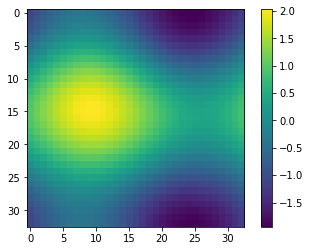

In [2]:
n = 2**5
rf = gr.gaussian_random_field(alpha=10.6, size=n+1)
im = plt.imshow(rf)
plt.colorbar(im)

In [3]:
class MeshSquareFEM():
    """ Handle a simple square mesh with quad elements
    0: background square
    
    Parameters:
        size: length of the square plate
        nnode_edge: number of nodes along edges of the plate
    """

    def __init__(self, size = 2, nnode_edge = 65, outfile = None):
        self.size = size
        self.nnode_edge = nnode_edge
        self.node_list = np.arange(nnode_edge*nnode_edge)
        self.mesh = None
        self.a = np.array([1.], dtype=np.float32) # Coefficients of linear Laplace equation
        self.mesh = self.generate_mesh()
        self.mesh.cell_data['Phase'] = np.zeros(((nnode_edge-1)*(nnode_edge-1),),dtype=int) # there is only one phase
        self.generate_node_index()
        
        if outfile is not None:
            self.save_mesh(outfile)

    def generate_mesh(self):
        x = np.linspace(self.size/2,-self.size/2,self.nnode_edge, dtype=np.float32)
        y = np.linspace(-self.size/2,self.size/2,self.nnode_edge, dtype=np.float32)
        ms_x, ms_y = np.meshgrid(x,y)
        x = np.ravel(ms_x).reshape(-1,1)
        y = np.ravel(ms_y).reshape(-1,1)
        z = np.zeros_like(x, dtype=np.float32)
        points = np.concatenate((x,y,z),axis=1)
        n_element = (self.nnode_edge-1)*(self.nnode_edge-1)
        nodes = np.linspace(0,points.shape[0],points.shape[0],endpoint=False,dtype=int).reshape(self.nnode_edge,self.nnode_edge)
        cells = np.zeros((n_element,4),dtype=int)
        cells[:,0] = np.ravel(nodes[:self.nnode_edge-1,:self.nnode_edge-1])
        cells[:,1] = np.ravel(nodes[:self.nnode_edge-1,1:])
        cells[:,2] = np.ravel(nodes[1:,1:])
        cells[:,3] = np.ravel(nodes[1:,:self.nnode_edge-1])
        return meshio.Mesh(points, [("quad",cells)])

    def generate_node_index(self):
        '''Generate node index matrix that indicate boundary (True) or internal nodes (False)'''
        node_index = []
        top = []
        bottom = []
        left = []
        right = []
        temp_bool = [False, False, False, False, False] # Top, Bottom, Left, Right, Boundary
        for pt in self.mesh.points:
            if (np.isclose(pt[0],-self.size/2)):
                temp_bool = [False, False, True, False, True]
            elif (np.isclose(pt[0],self.size/2)):
                temp_bool = [False, False, False, True, True]
            elif (np.isclose(pt[1],-self.size/2)):
                temp_bool = [False, True, False, False, True]
            elif (np.isclose(pt[1],self.size/2)):
                temp_bool = [True, False, False, False, True]
            else:
                temp_bool = [False, False, False, False, False]
            
            top.append(temp_bool[0])
            bottom.append(temp_bool[1])
            left.append(temp_bool[2])
            right.append(temp_bool[3])
            node_index.append(temp_bool[4])

        self.node_top = self.node_list[top]
        self.node_bottom = self.node_list[bottom]
        self.node_left = self.node_list[left]
        self.node_right = self.node_list[right]
        self.node_essential = self.node_list[node_index]
        self.node_internal = self.node_list[np.invert(node_index)]
    
    def shapefunc(self, p):
        # shape function
        N = 0.25*np.array([[(1-p[0])*(1-p[1])],
                           [(1+p[0])*(1-p[1])],
                           [(1+p[0])*(1+p[1])],
                           [(1-p[0])*(1+p[1])]])

        dNdp = 0.25*np.array([[-(1-p[1]), -(1-p[0])],
                              [(1-p[1]), -(1+p[0])],
                              [(1+p[1]), (1+p[0])],
                              [-(1+p[1]), (1-p[0])]])
        return N, dNdp

    def save_mesh(self,outfile = 'mesh_square.vtk'):
        self.mesh.write(outfile)

In [4]:
class GridFEM():
    '''
    Note: the n should be the number of elements along edges, e.g., 
    there are (n-1)*(n-1) internal grid points 
    '''
    def __init__(self, n, size = 2):
        self.size = size
        self.n = n 
        self.omega = 2/3
        self.qpts = np.array([[-1, 1, 1, -1], [-1, -1, 1, 1]])/np.sqrt(3) #[2x4]
        self.d = np.zeros((n+1)*(n+1))
        self.f = np.zeros((n+1)*(n+1))
        self.grid = MeshSquareFEM(size, nnode_edge=n+1)
        self.A, self.A_EF = self.CreateA()
        
    def CreateA(self):
        '''
        Stiffness matrix, return A_F and A_EF 
        ''' 
        A = np.zeros(((self.n+1)*(self.n+1),(self.n+1)*(self.n+1)))
        for c in self.grid.mesh.cells_dict['quad']:
            xe = self.grid.mesh.points[c,:].T[:2,:] #[2x4]
            D = np.eye(2)
            Ke = np.zeros((4,4))
            for q in self.qpts.T:
                [_,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                dNdx = np.dot(dNdp, np.linalg.inv(J)) #[4x2]
                B = np.zeros((2,4))
                B[0,:] = dNdx[:,0]
                B[1,:] = dNdx[:,1]
                Ke += np.linalg.det(J)*np.dot(B.T,np.dot(D,B))
            A[np.ix_(c,c)] += Ke
            
        return A[np.ix_(self.grid.node_internal,self.grid.node_internal)], A[np.ix_(self.grid.node_essential,self.grid.node_internal)]

    def UpdateRHS(self, f = None):
        '''
        Return the rhs internal sourcing term with modification from finite element term
        '''
        if(f is None):
            f = np.random.rand((self.n+1)*(self.n+1))
        ff = np.zeros_like(f)
        for c in self.grid.mesh.cells_dict['quad']:
            xe = self.grid.mesh.points[c,:].T[:2,:] #[2x4]
            fe = np.zeros(4)
            for q in self.qpts.T:
                [N,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                temp = np.linalg.det(J)*np.dot(N,np.dot(N.T,f[c])) #[4x1]
                fe += temp
            ff[c] += fe
        return ff[self.grid.node_internal]
    
    def SetBC(self, bc_value = None):
        '''Boundary values order: top, bottom, left, right'''
        if (bc_value is None):
            bc_value = np.random.rand(4)
        self.d[self.grid.node_top] = bc_value[0]
        self.d[self.grid.node_bottom] = bc_value[1]
        self.d[self.grid.node_left] = bc_value[2]
        self.d[self.grid.node_right] = bc_value[3]
        return self.d[self.grid.node_essential]

    def GaussianRF(self):
        alpha = random.uniform(-10,10)
        a = random.uniform(0,20)
        rf = a*gr.gaussian_random_field(alpha=alpha, size=self.n+1)
        return rf.reshape((self.n+1)*(self.n+1))

    def Solve(self, bc=None, f=None):
        '''
        Solve the linear equation system
        '''
        if(f is None):
            f = self.GaussianRF()
        d_E = self.SetBC(bc)
        f_F = self.UpdateRHS(f)
        b = f_F - np.dot(self.A_EF.T, d_E)
        d_F = np.linalg.solve(self.A, b)
        self.d[self.grid.node_internal] = d_F

    def PlotField(self, field = None):
        '''Default is to plot the solution field'''
        if(field is None):
            field = self.d
        
        field2d = field.reshape((self.n+1, self.n+1))
        im = plt.imshow(field2d)
        
        ax = plt.gca()
        ax.invert_xaxis()
        ax.invert_yaxis()
        plt.axis('off')
        plt.colorbar(im)
        plt.show()

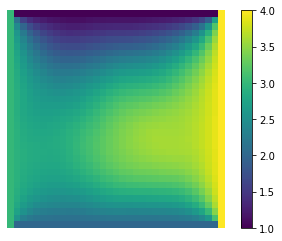

In [5]:
n = 2**5
prob = GridFEM(n)
prob.Solve(bc=[1,2,3,4])
prob.PlotField()

In [6]:
# Define boundary values 
def bc_setting(n, bc_values):
    '''
    n is node number along edges
    Order of bc_values: top, bottom, left, right'''

    # Define geometry, 1.0 inner points; 0.0 elsewhre
    geometry_idx = np.ones((n,n))
    geometry_idx[0,  :] = np.zeros(n)
    geometry_idx[-1,  :] = np.zeros(n)
    geometry_idx[:,  0] = np.zeros(n)
    geometry_idx[:, -1] = np.zeros(n)

    boundary_value = np.zeros_like(geometry_idx)
    boundary_value[-1, :] = bc_values[0]
    boundary_value[0, :] = bc_values[1]
    boundary_value[:,-1] = bc_values[2]
    boundary_value[:, 0] = bc_values[3]
    
    return geometry_idx, boundary_value

In [7]:
# Create dataset
dataset = {}
n_data = 1000
bc_index_data = np.zeros((n_data, n+1, n+1))
bc_value_data = np.zeros((n_data, n+1, n+1))
f_data = np.zeros((n_data, n+1, n+1))
u_data = np.zeros((n_data, n+1, n+1))
for i in range(n_data):
    f = prob.GaussianRF()
    bc = np.random.rand(4)
    prob.Solve(bc=bc, f = f)
    geometry_idx, boundary_value = bc_setting(n+1, bc)
    bc_index_data[i,:,:] = geometry_idx
    bc_value_data[i,:,:] = boundary_value
    f_data[i,:,:] = f.reshape((n+1, n+1))
    u_data[i,:,:] = prob.d.reshape((n+1, n+1))
    print("Problem #-"+str(i)+" solved")

Problem #-0 solved
Problem #-1 solved
Problem #-2 solved
Problem #-3 solved
Problem #-4 solved
Problem #-5 solved
Problem #-6 solved
Problem #-7 solved
Problem #-8 solved
Problem #-9 solved
Problem #-10 solved
Problem #-11 solved
Problem #-12 solved
Problem #-13 solved
Problem #-14 solved
Problem #-15 solved
Problem #-16 solved
Problem #-17 solved
Problem #-18 solved
Problem #-19 solved
Problem #-20 solved
Problem #-21 solved
Problem #-22 solved
Problem #-23 solved
Problem #-24 solved
Problem #-25 solved
Problem #-26 solved
Problem #-27 solved
Problem #-28 solved
Problem #-29 solved
Problem #-30 solved
Problem #-31 solved
Problem #-32 solved
Problem #-33 solved
Problem #-34 solved
Problem #-35 solved
Problem #-36 solved
Problem #-37 solved
Problem #-38 solved
Problem #-39 solved
Problem #-40 solved
Problem #-41 solved
Problem #-42 solved
Problem #-43 solved
Problem #-44 solved
Problem #-45 solved
Problem #-46 solved
Problem #-47 solved
Problem #-48 solved
Problem #-49 solved
Problem #-

In [8]:
dataset['boundary_index'] = bc_index_data
dataset['boundary_value'] = bc_value_data
dataset['rhs'] = f_data
dataset['u'] = u_data

with h5py.File("poisson2d_33x33.h5", "w") as hf:
    for key, item in dataset.items():
        hf[key] = item